In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics

from xgboost import XGBClassifier


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

# def Logistic_model(X_train,Y_train,X_test,Y_test):
#     print('\033[1m' + 'Logistic Regression' + '\033[0m')
#     log=LogisticRegression()
#     log.fit(X_train,Y_train)
    
#     return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    precision=precision_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    recall=recall_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

In [4]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)
Shape of URL dataset: (46771, 4194)


In [5]:
df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of combined dataset: (39183, 6726)


0    34742
1     4441
Name: Target, dtype: int64

In [6]:
columns=['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

print("features being used")
display(columns)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

In [7]:
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)

### <a id='1' style="text-decoration : none; color : #000000;"> 1. Initial Models</a>

In [8]:
df_sel=df[columns].copy(deep=True)

train=df_sel.iloc[:31346,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[31346:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9795189178842596
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27606   199    27805
True         443  3098     3541
__all__    28049  3297    31346

Accuracy of the model for test data is: 0.9724384330738803
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6858    79     6937
True         137   763      900
__all__     6995   842     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9961398583551331
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27783    22    27805
True          99  3442     3541
__all__    27882  3464    31346

Accuracy of the model for test data is: 0.9795840244991706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6894    43     6937
True         117   783      900
__all__     7011   826     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9739998723920117
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27482   323    27805
True         492  3049     3541
__all__    27974  3372    31346

Accuracy of the model for test data is: 0.9697588362893964
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6845    92     6937
True         145   755      900
__all__     6990   847     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9798698398519747
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27632   173    27805
True         458  3083     3541
__all__    28090  3256    31346

Accuracy of the model for test data is: 0.9755008293990047
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6881    56     6937
True         136   764      900
__all__     7017   820     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9977349582083839
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27802     3    27805
True          68  3473     3541
__all__    27870  3476    31346

Accuracy of the model for test data is: 0.9767768278678065
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6890    47     6937
True         135   765      900
__all__     7025   812     7837



XGB Classifier
Accuracy of the model for training data is: 0.9792317999106744
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27633   172    27805
True         479  3062     3541
__all__    28112  3234    31346

Accuracy of the model for test data is: 0.9755008293990047
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6883    54     6937
True         138   762      900
__all__     7021   816     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9958846423786128
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27774    31    27805
True          98  3443     3541
__all__    27872  3474    31346

Accuracy of the model for test data is: 0.9761388286334056
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6879    58     6937
True         129   771      900
__all__     7008   829     7837



Neural Network-1
The accuracy of the model on training data is: 0.9924392266955911


Predicted  False  True  __all__
Actual                         
False      27718    87    27805
True         150  3391     3541
__all__    27868  3478    31346

The accuracy of the model on test data is: 0.9724384330738803


Predicted  False  True  __all__
Actual                         
False       6847    90     6937
True         126   774      900
__all__     6973   864     7837

### <a id='1.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [9]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [10]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.979519,3098.0,27606.0,199.0,443.0,0.007157,0.125106
RandomForestClassifier,0.996140,3442.0,27783.0,22.0,99.0,0.000791,0.027958
AdaBoostClassifier,0.974000,3049.0,27482.0,323.0,492.0,0.011617,0.138944
GradientBoostingClassifier,0.979870,3083.0,27632.0,173.0,458.0,0.006222,0.129342
ExtraTreeClassifier,0.997735,3473.0,27802.0,3.0,68.0,0.000108,0.019204
XGB,0.979232,3062.0,27633.0,172.0,479.0,0.006186,0.135273
BaggingClassifier,0.995885,3443.0,27774.0,31.0,98.0,0.001115,0.027676
Neural Network-1,0.992439,3391.0,27718.0,87.0,150.0,0.003129,0.042361


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.972438,763.0,6858.0,79.0,137.0,0.011388,0.152222,0.918195,0.861124,0.906176,0.847778
RandomForestClassifier,0.979584,783.0,6894.0,43.0,117.0,0.006199,0.130000,0.931901,0.896894,0.947942,0.870000
AdaBoostClassifier,0.969759,755.0,6845.0,92.0,145.0,0.013262,0.161111,0.912813,0.847833,0.891381,0.838889
GradientBoostingClassifier,0.975501,764.0,6881.0,56.0,136.0,0.008073,0.151111,0.920408,0.875842,0.931707,0.848889
ExtraTreeClassifier,0.976777,765.0,6890.0,47.0,135.0,0.006775,0.150000,0.921612,0.882164,0.942118,0.850000
XGB,0.975501,762.0,6883.0,54.0,138.0,0.007784,0.153333,0.919441,0.875717,0.933824,0.846667
BaggingClassifier,0.976139,771.0,6879.0,58.0,129.0,0.008361,0.143333,0.924153,0.879397,0.930036,0.856667
Neural Network-1,0.972438,774.0,6847.0,90.0,126.0,0.012974,0.140000,0.924153,0.862258,0.895833,0.860000


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [11]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [12]:
sm = SMOTE(random_state=12, ratio = {1:27805})
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)


ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9803092968890488
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26847    958    27805
True         137  27668    27805
__all__    26984  28626    55610

Accuracy of the model for test data is: 0.9420696695163966
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6570   367     6937
True          87   813      900
__all__     6657  1180     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9979140442366481
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27764     41    27805
True          75  27730    27805
__all__    27839  27771    55610

Accuracy of the model for test data is: 0.9770320275615669
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6868    69     6937
True         111   789      900
__all__     6979   858     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9575256248876102
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26525   1280    27805
True        1082  26723    27805
__all__    27607  28003    55610

Accuracy of the model for test data is: 0.9511292586448896
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6620   317     6937
True          66   834      900
__all__     6686  1151     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9716777557993167
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27025    780    27805
True         795  27010    27805
__all__    27820  27790    55610

Accuracy of the model for test data is: 0.963251244098507
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6730   207     6937
True          81   819      900
__all__     6811  1026     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9987232512138104
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27802      3    27805
True          68  27737    27805
__all__    27870  27740    55610

Accuracy of the model for test data is: 0.9771596274084471
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6863    74     6937
True         105   795      900
__all__     6968   869     7837



XGB Classifier
Accuracy of the model for training data is: 0.9700233770904514
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26955    850    27805
True         817  26988    27805
__all__    27772  27838    55610

Accuracy of the model for test data is: 0.9622304453234656
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6719   218     6937
True          78   822      900
__all__     6797  1040     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9977522028412156
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27766     39    27805
True          86  27719    27805
__all__    27852  27758    55610

Accuracy of the model for test data is: 0.9732040321551614
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6845    92     6937
True         118   782      900
__all__     6963   874     7837



Neural Network-1
The accuracy of the model on training data is: 0.9912605646466462


Predicted  False   True  __all__
Actual                          
False      27639    166    27805
True         320  27485    27805
__all__    27959  27651    55610

The accuracy of the model on test data is: 0.966696439964272


Predicted  False  True  __all__
Actual                         
False       6784   153     6937
True         108   792      900
__all__     6892   945     7837

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [13]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [14]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980309,27668.0,26847.0,958.0,137.0,0.034454,0.004927
RandomForestClassifier,0.997914,27730.0,27764.0,41.0,75.0,0.001475,0.002697
AdaBoostClassifier,0.957526,26723.0,26525.0,1280.0,1082.0,0.046035,0.038914
GradientBoostingClassifier,0.971678,27010.0,27025.0,780.0,795.0,0.028053,0.028592
ExtraTreeClassifier,0.998723,27737.0,27802.0,3.0,68.0,0.000108,0.002446
XGB,0.970023,26988.0,26955.0,850.0,817.0,0.030570,0.029383
BaggingClassifier,0.997752,27719.0,27766.0,39.0,86.0,0.001403,0.003093
Neural Network-1,0.991261,27485.0,27639.0,166.0,320.0,0.005970,0.011509


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.942070,813.0,6570.0,367.0,87.0,0.052905,0.096667,0.925214,0.758167,0.688983,0.903333
RandomForestClassifier,0.977032,789.0,6868.0,69.0,111.0,0.009947,0.123333,0.933360,0.885005,0.919580,0.876667
AdaBoostClassifier,0.951129,834.0,6620.0,317.0,66.0,0.045697,0.073333,0.940485,0.793501,0.724587,0.926667
GradientBoostingClassifier,0.963251,819.0,6730.0,207.0,81.0,0.029840,0.090000,0.940080,0.831935,0.798246,0.910000
ExtraTreeClassifier,0.977160,795.0,6863.0,74.0,105.0,0.010667,0.116667,0.936333,0.886117,0.914845,0.883333
XGB,0.962230,822.0,6719.0,218.0,78.0,0.031426,0.086667,0.940954,0.828810,0.790385,0.913333
BaggingClassifier,0.973204,782.0,6845.0,92.0,118.0,0.013262,0.131111,0.927813,0.866638,0.894737,0.868889
Neural Network-1,0.966696,792.0,6784.0,153.0,108.0,0.022056,0.120000,0.927813,0.839997,0.838095,0.880000


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [15]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;">3. UnderSampling </a>

In [16]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

Shape after undersampling (7082, 34)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.9502965264049703
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3375   166     3541
True         186  3355     3541
__all__     3561  3521     7082

Accuracy of the model for test data is: 0.9289268852877377
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6456   481     6937
True          76   824      900
__all__     6532  1305     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9927986444507201
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3524    17     3541
True          34  3507     3541
__all__     3558  3524     7082

Accuracy of the model for test data is: 0.9547020543575347
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6642   295     6937
True          60   840      900
__all__     6702  1135     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9402711098559728
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3305   236     3541
True         187  3354     3541
__all__     3492  3590     7082

Accuracy of the model for test data is: 0.9391348730381524
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6516   421     6937
True          56   844      900
__all__     6572  1265     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9543914148545608
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3382   159     3541
True         164  3377     3541
__all__     3546  3536     7082

Accuracy of the model for test data is: 0.9526604568074518
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6619   318     6937
True          53   847      900
__all__     6672  1165     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9967523298503248
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3540     1     3541
True          22  3519     3541
__all__     3562  3520     7082

Accuracy of the model for test data is: 0.9575092509888988
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6669   268     6937
True          65   835      900
__all__     6734  1103     7837



XGB Classifier
Accuracy of the model for training data is: 0.9515673538548433
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3376   165     3541
True         178  3363     3541
__all__     3554  3528     7082

Accuracy of the model for test data is: 0.95138445833865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6613   324     6937
True          57   843      900
__all__     6670  1167     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9920926292007908
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3518    23     3541
True          33  3508     3541
__all__     3551  3531     7082

Accuracy of the model for test data is: 0.9515120581855302
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6627   310     6937
True          70   830      900
__all__     6697  1140     7837



Neural Network-1
The accuracy of the model on training data is: 0.9857384919514262


Predicted  False  True  __all__
Actual                         
False       3488    53     3541
True          48  3493     3541
__all__     3536  3546     7082

The accuracy of the model on test data is: 0.9373484751818297


Predicted  False  True  __all__
Actual                         
False       6504   433     6937
True          58   842      900
__all__     6562  1275     7837

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [17]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [18]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.950297,3355.0,3375.0,166.0,186.0,0.046879,0.052528
RandomForestClassifier,0.992799,3507.0,3524.0,17.0,34.0,0.004801,0.009602
AdaBoostClassifier,0.940271,3354.0,3305.0,236.0,187.0,0.066648,0.052810
GradientBoostingClassifier,0.954391,3377.0,3382.0,159.0,164.0,0.044903,0.046315
ExtraTreeClassifier,0.996752,3519.0,3540.0,1.0,22.0,0.000282,0.006213
XGB,0.951567,3363.0,3376.0,165.0,178.0,0.046597,0.050268
BaggingClassifier,0.992093,3508.0,3518.0,23.0,33.0,0.006495,0.009319
Neural Network-1,0.985738,3493.0,3488.0,53.0,48.0,0.014968,0.013555


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.928927,824.0,6456.0,481.0,76.0,0.069338,0.084444,0.923109,0.724203,0.631418,0.915556
RandomForestClassifier,0.954702,840.0,6642.0,295.0,60.0,0.042526,0.066667,0.945404,0.807032,0.740088,0.933333
AdaBoostClassifier,0.939135,844.0,6516.0,421.0,56.0,0.060689,0.062222,0.938544,0.760075,0.667194,0.937778
GradientBoostingClassifier,0.952660,847.0,6619.0,318.0,53.0,0.045841,0.058889,0.947635,0.802362,0.727039,0.941111
ExtraTreeClassifier,0.957509,835.0,6669.0,268.0,65.0,0.038633,0.072222,0.944572,0.815183,0.757026,0.927778
XGB,0.951384,843.0,6613.0,324.0,57.0,0.046706,0.063333,0.944980,0.797039,0.722365,0.936667
BaggingClassifier,0.951512,830.0,6627.0,310.0,70.0,0.044688,0.077778,0.938767,0.793558,0.728070,0.922222
Neural Network-1,0.937348,842.0,6504.0,433.0,58.0,0.062419,0.064444,0.938767,0.754251,0.660392,0.935556


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [19]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [20]:
df.reset_index(inplace=True)
columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2278 features
EntitySet scattered to workers in 4.625 seconds
Elapsed: 00:12 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [21]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [ ]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y)

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()

In [ ]:
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [ ]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)
print('Features we will be using:\n')
display(feature_name)

In [23]:
feature_name=['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_header_server_apache + url_extensions',
 'http_header_content-encoding_gzip / url_char_.',
 'a_href_relative / a_count',
 'a_href_out_of_domain / total_href',
 'a_href_https / a_count']

In [24]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:31346]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[31346:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9797103298666496
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27615   190    27805
True         446  3095     3541
__all__    28061  3285    31346

Accuracy of the model for test data is: 0.9709072349113181
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6858    79     6937
True         149   751      900
__all__     7007   830     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9948956804695974
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27776    29    27805
True         131  3410     3541
__all__    27907  3439    31346

Accuracy of the model for test data is: 0.9775424269490877
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6883    54     6937
True         122   778      900
__all__     7005   832     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9737127544184266
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27507   298    27805
True         526  3015     3541
__all__    28033  3313    31346

Accuracy of the model for test data is: 0.9682276381268342
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6838    99     6937
True         150   750      900
__all__     6988   849     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.98028456581382
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27649   156    27805
True         462  3079     3541
__all__    28111  3235    31346

Accuracy of the model for test data is: 0.975756029092765
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6888    49     6937
True         141   759      900
__all__     7029   808     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9969374082817585
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27797     8    27805
True          88  3453     3541
__all__    27885  3461    31346

Accuracy of the model for test data is: 0.9767768278678065
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6887    50     6937
True         132   768      900
__all__     7019   818     7837

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method



XGB Classifier
Accuracy of the model for training data is: 0.9788808779429592
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27657   148    27805
True         514  3027     3541
__all__    28171  3175    31346

Accuracy of the model for test data is: 0.9747352303177236
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6886    51     6937
True         147   753      900
__all__     7033   804     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9948318764754673
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27773    32    27805
True         130  3411     3541
__all__    27903  3443    31346

Accuracy of the model for test data is: 0.9770320275615669
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6877    60     6937
True         120   780      900
__all__     6997   840     7837



Neural Network-1
The accuracy of the model on training data is: 0.9858993172972628


Predicted  False  True  __all__
Actual                         
False      27630   175    27805
True         267  3274     3541
__all__    27897  3449    31346

The accuracy of the model on test data is: 0.9719280336863596


Predicted  False  True  __all__
Actual                         
False       6828   109     6937
True         111   789      900
__all__     6939   898     7837

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.979710,3095.0,27615.0,190.0,446.0,0.006833,0.125953
RandomForestClassifier,0.994896,3410.0,27776.0,29.0,131.0,0.001043,0.036995
AdaBoostClassifier,0.973713,3015.0,27507.0,298.0,526.0,0.010717,0.148546
GradientBoostingClassifier,0.980285,3079.0,27649.0,156.0,462.0,0.005611,0.130472
ExtraTreeClassifier,0.996937,3453.0,27797.0,8.0,88.0,0.000288,0.024852
XGB,0.978881,3027.0,27657.0,148.0,514.0,0.005323,0.145157
BaggingClassifier,0.994832,3411.0,27773.0,32.0,130.0,0.001151,0.036713
Neural Network-1,0.985899,3274.0,27630.0,175.0,267.0,0.006294,0.075402


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.970907,751.0,6858.0,79.0,149.0,0.011388,0.165556,0.911528,0.852769,0.904819,0.834444
RandomForestClassifier,0.977542,778.0,6883.0,54.0,122.0,0.007784,0.135556,0.928330,0.886645,0.935096,0.864444
AdaBoostClassifier,0.968228,750.0,6838.0,99.0,150.0,0.014271,0.166667,0.909531,0.840221,0.883392,0.833333
GradientBoostingClassifier,0.975756,759.0,6888.0,49.0,141.0,0.007064,0.156667,0.918135,0.876801,0.939356,0.843333
ExtraTreeClassifier,0.976777,768.0,6887.0,50.0,132.0,0.007208,0.146667,0.923063,0.882323,0.938875,0.853333
XGB,0.974735,753.0,6886.0,51.0,147.0,0.007352,0.163333,0.914657,0.871421,0.936567,0.836667
BaggingClassifier,0.977032,780.0,6877.0,60.0,120.0,0.008649,0.133333,0.929009,0.884316,0.928571,0.866667
Neural Network-1,0.971928,789.0,6828.0,109.0,111.0,0.015713,0.123333,0.929009,0.861788,0.878619,0.876667


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 83.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

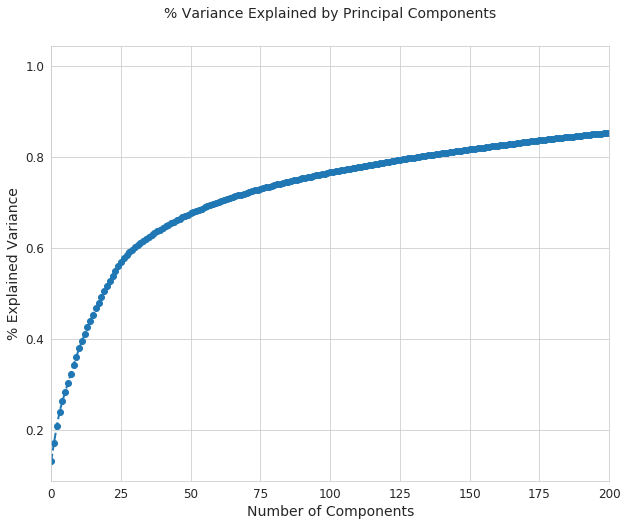

In [28]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [29]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 125 components is: 0.791882110553281


In [30]:
X_train=X_pca_21[:31346]
Y_train=fs.iloc[:31346]['Target'].values
X_test=X_pca_21[31346:]
Y_test=fs.iloc[31346:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [31]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,125).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9809545077521853
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27647   158    27805
True         439  3102     3541
__all__    28086  3260    31346

Accuracy of the model for test data is: 0.9703968355237974
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6866    71     6937
True         161   739      900
__all__     7027   810     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9956932303962228
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27783    22    27805
True         113  3428     3541
__all__    27896  3450    31346

Accuracy of the model for test data is: 0.9733316320020416
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6883    54     6937
True         155   745      900
__all__     7038   799     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9729790084859312
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27483   322    27805
True         525  3016     3541
__all__    28008  3338    31346

Accuracy of the model for test data is: 0.9670792395049126
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6833   104     6937
True         154   746      900
__all__     6987   850     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9798698398519747
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27651   154    27805
True         477  3064     3541
__all__    28128  3218    31346

Accuracy of the model for test data is: 0.9725660329207605
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6870    67     6937
True         148   752      900
__all__     7018   819     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9977349582083839
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27802     3    27805
True          68  3473     3541
__all__    27870  3476    31346

Accuracy of the model for test data is: 0.9700140359831568
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6890    47     6937
True         188   712      900
__all__     7078   759     7837



XGB Classifier
Accuracy of the model for training data is: 0.9797103298666496
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27651   154    27805
True         482  3059     3541
__all__    28133  3213    31346

Accuracy of the model for test data is: 0.9734592318489218
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6875    62     6937
True         146   754      900
__all__     7021   816     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9956613283991578
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27780    25    27805
True         111  3430     3541
__all__    27891  3455    31346

Accuracy of the model for test data is: 0.9742248309302028
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6880    57     6937
True         145   755      900
__all__     7025   812     7837



Neural Network-1
The accuracy of the model on training data is: 0.9949594844637274


Predicted  False  True  __all__
Actual                         
False      27732    73    27805
True          85  3456     3541
__all__    27817  3529    31346

The accuracy of the model on test data is: 0.9716728339925992


Predicted  False  True  __all__
Actual                         
False       6830   107     6937
True         115   785      900
__all__     6945   892     7837

In [32]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [33]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980955,3102.0,27647.0,158.0,439.0,0.005682,0.123976
RandomForestClassifier,0.995693,3428.0,27783.0,22.0,113.0,0.000791,0.031912
AdaBoostClassifier,0.972979,3016.0,27483.0,322.0,525.0,0.011581,0.148263
GradientBoostingClassifier,0.979870,3064.0,27651.0,154.0,477.0,0.005539,0.134708
ExtraTreeClassifier,0.997735,3473.0,27802.0,3.0,68.0,0.000108,0.019204
XGB,0.979710,3059.0,27651.0,154.0,482.0,0.005539,0.136120
BaggingClassifier,0.995661,3430.0,27780.0,25.0,111.0,0.000899,0.031347
Neural Network-1,0.994959,3456.0,27732.0,73.0,85.0,0.002625,0.024005


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.970397,739.0,6866.0,71.0,161.0,0.010235,0.178889,0.905438,0.849247,0.912346,0.821111
RandomForestClassifier,0.973332,745.0,6883.0,54.0,155.0,0.007784,0.172222,0.909997,0.864011,0.932416,0.827778
AdaBoostClassifier,0.967079,746.0,6833.0,104.0,154.0,0.014992,0.171111,0.906948,0.834491,0.877647,0.828889
GradientBoostingClassifier,0.972566,752.0,6870.0,67.0,148.0,0.009658,0.164444,0.912949,0.860765,0.918193,0.835556
ExtraTreeClassifier,0.970014,712.0,6890.0,47.0,188.0,0.006775,0.208889,0.892168,0.845538,0.938076,0.791111
XGB,0.973459,754.0,6875.0,62.0,146.0,0.008938,0.162222,0.914420,0.865234,0.924020,0.837778
BaggingClassifier,0.974225,755.0,6880.0,57.0,145.0,0.008217,0.161111,0.915336,0.869032,0.929803,0.838889
Neural Network-1,0.971673,785.0,6830.0,107.0,115.0,0.015425,0.127778,0.915336,0.860135,0.880045,0.872222


In [34]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')